In [1]:
import numpy as np 
import tensorflow as tf

2025-07-26 15:31:57.448363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-26 15:31:57.459694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753524117.474539  181723 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753524117.478512  181723 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753524117.488010  181723 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available: 1


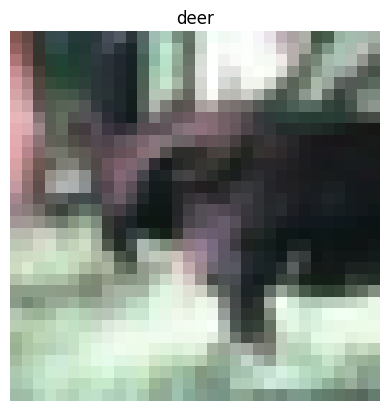

In [4]:
(x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()

label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
    
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}

idx = np.random.randint(len(x_train))
img = x_train[idx]

plt.imshow(img)
plt.axis('off')
plt.title(label_dict[y_train[idx][0]])
plt.show()

In [5]:
latent_dim = 100
class_nums = 10
img_dim = img.shape

In [6]:
def build_generator(l_dim, class_nums):
    noise_input = layers.Input(shape=(l_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # int label into one-hot code
    # label_oh = layers.Lambda(lambda x: tf.one_hot(tf.squeeze(x, axis=-1), depth=class_nums), output_shape=(class_nums,)) (label_input)
    # combined_oh_input = layers.Concatenate(axis=-1) ([noise_input, label_oh])

    # label Embedding
    label_embed = layers.Embedding(input_dim=10, output_dim=50) (label_input)
    label_embd_flat = layers.Flatten() (label_embed)
    combined_emb_input = layers.Concatenate(axis = -1)([noise_input, label_embd_flat])

    # (150,) -> (4, 4, 256)
    x = layers.Dense(units=4*4*256, activation='relu') (combined_emb_input)
    x = layers.Reshape((4, 4, 256)) (x)

    # (4, 4, 256) -> (4, 4, 128)
    x = layers.Conv2D(128, kernel_size=2, strides=1, padding='same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.ReLU()(x)

    # (4, 4, 128) -> (8, 8, 64)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.ReLU() (x)

    #  (8, 8, 64) -> (16, 16, 32)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.ReLU() (x)

    # (16, 16, 32) -> (32, 32, 16)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(16, kernel_size=2, strides=1, padding='same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.ReLU()(x)

    # (32, 32, 16) -> (32, 32, 3)
    x = layers.Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh') (x)

    model = Model([noise_input, label_input], x)

    return model

I0000 00:00:1753524122.424977  181723 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1753524123.228390  181788 service.cc:152] XLA service 0x7cbcd800a060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753524123.228413  181788 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-07-26 15:32:03.244209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753524123.299759  181788 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


I0000 00:00:1753524123.947179  181788 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


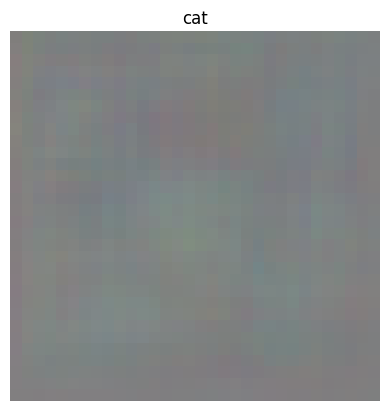

In [7]:
gen = build_generator(100, 10)

label = np.random.randint(0, class_nums, (1, 1))
noise = np.random.uniform(-1, 1, (1, 100))
img = gen.predict([noise, label])

img = 0.5*img + 0.5
plt.imshow(img[0])
plt.title(label=label_dict[label[0][0]])
plt.axis('off')
plt.show()

In [8]:
img[0].shape

(32, 32, 3)

In [9]:
def build_discriminator(input_dim):
    img_input = layers.Input(shape=input_dim)

    # (32, 32, 3) -> (16, 16, 32)
    x = layers.Conv2D(32, kernel_size=(3,3), strides=2, padding='same') (img_input)
    x = layers.LeakyReLU(negative_slope=0.2) (x)
    x = layers.Dropout(0.3) (x)

    # (16, 16, 32) -> (8, 8, 64)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=2, padding='same') (x)
    x = layers.LeakyReLU(negative_slope=0.2) (x)
    x = layers.Dropout(0.3) (x)

    # (8, 8, 64) -> (4, 4, 128)
    x = layers.Conv2D(128, kernel_size=(3,3), strides=2, padding='same') (x)
    x = layers.LeakyReLU(negative_slope=0.2) (x)
    x = layers.Dropout(0.3) (x)

    x = layers.Flatten() (x)

    validity = layers.Dense(1, activation='sigmoid') (x)
    label = layers.Dense(10, activation='softmax') (x)

    model = Model(img_input, [validity, label])

    return model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


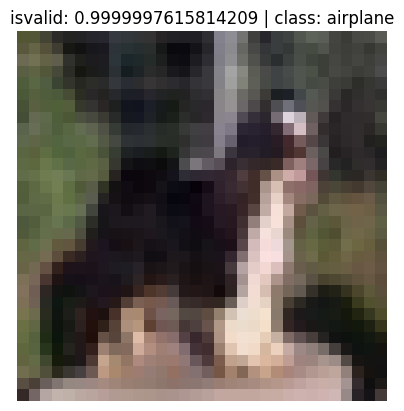

In [10]:
disc = build_discriminator(img_dim)
idx = np.random.randint(len(x_train))
img = x_train[idx]
img = np.expand_dims(img, axis=0)

validity, label_prob = disc.predict(img)
label = np.argmax(label_prob[0])

plt.imshow(img[0])
plt.axis('off')
plt.title(f"isvalid: {validity[0][0]} | class: {label_dict[label]}")
plt.show()

In [11]:
def build_model(latent_dim = latent_dim, class_nums = class_nums, img_dim = img_dim):
    Gen = build_generator(latent_dim, class_nums)
    Disc = build_discriminator(img_dim)

    Disc.trainable = False

    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    image_input = Gen([noise_input, label_input])
    val, label_prob = Disc(image_input)

    combined = Model([noise_input, label_input], [val, label_prob])

    combined.compile(
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5),
        metrics = ['accuracy', 'accuracy']
    )

    Disc.trainable = True
    Disc.compile(
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
        loss_weights=[1, 1],
        optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
        metrics = ['accuracy', 'accuracy']
    )

    return Gen, Disc, combined

In [12]:
Gen, Disc, comb_model = build_model()

In [13]:
def train_model(epochs, x_train, y_train, Gen = Gen, Disc = Disc, comb_model=comb_model, latent_dim = latent_dim, class_nums = class_nums, img_dim = img_dim, batch=64):
    d_loss, g_loss=[], []


    for epoch in range(1, epochs+1):
        # real and fake annotations
        real_batch_label = np.ones((batch, 1))*np.random.uniform(0.9,1)
        fake_batch_label = np.ones((batch, 1))*np.random.uniform(0, 0.1)

        # creating fake imgs from noise and class codes
        noise = np.random.uniform(-1, 1, (batch, latent_dim))
        fake_class = np.random.randint(0, class_nums, (batch, 1))
        fake_imgs = Gen.predict([noise, fake_class], verbose=0)

        # selecting random real imgs from training set
        idx = np.random.randint(0, len(x_train), batch)
        real_imgs = x_train[idx]
        real_class = y_train[idx]

        # training the discriminator
        Disc.trainable = True
        disc_lossforreal = np.array(Disc.train_on_batch(real_imgs, [real_batch_label, real_class]))
        disc_lossforfake = np.array(Disc.train_on_batch(fake_imgs, [fake_batch_label, fake_class]))
        disc_loss = (disc_lossforfake*0.5 + disc_lossforreal*0.5)
        d_loss.append(disc_loss)

        # generating new noise for generator training
        noise = np.random.uniform(-1, 1, (batch, latent_dim))
        fake_class = np.random.randint(0, class_nums, (batch, 1))

        # training the generator
        Disc.trainable=False
        comb_loss = np.array(comb_model.train_on_batch([noise, fake_class], [real_batch_label, fake_class]))
        g_loss.append(comb_loss)

        # printing the loss and accuracy every 50 epochs
        if((epoch) % 100 == 0):
            print(f"{epoch}/{epochs} | d_loss = {disc_loss[0]}, d_valid_accuracy = {disc_loss[3]}, d_class accuracy = {disc_loss[4]}| comb_loss = {comb_loss[0]}, accuracy(valid, class) = ({g_loss[3]}, {g_loss[4]})")
        if((epoch) % 500 == 0):
            noise = np.random.uniform(-1, 1, (class_nums, latent_dim))
            labels = np.arange(0, class_nums).reshape(-1, 1)
            imgs = Gen.predict([noise, labels], verbose=0)

            imgs = (imgs+1)*0.5
            # imgs = 1-imgs -------to get background as white instead of black
            c= 5
            r = class_nums//c

            fig, axs = plt.subplots(r, c, figsize=(10, 4))

            for i in range(r):
                for j in range(c):
                    axs[i][j].imshow(imgs[i*c+j])
                    axs[i][j].set_title(label_dict[labels[i*c+j][0]])
                    axs[i][j].axis('off')
            
            fig.suptitle(f"@epoch {epoch}")
            plt.tight_layout()
            plt.show()

    d_loss = np.array(d_loss)
    g_loss = np.array(g_loss)

    # plotting the metrics
    disc_metrics_names = ['d_total_loss', 'd_val_loss', 'd_class_loss', 'd_valid_acc', 'd_class_acc']
    comb_metrics_names = ['g_total_loss', 'g_val_loss', 'g_class_loss', 'g_valid_acc', 'g_class_acc']

    for i in range(max(len(d_loss[0]), len(g_loss[0]))):
        plt.plot(d_loss[:,i], label=disc_metrics_names[i])
        plt.plot(g_loss[:,i], label=comb_metrics_names[i])
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.title('training loss')
    plt.show()

    return d_loss, g_loss

In [14]:
x_train.shape

(50000, 32, 32, 3)

In [15]:
# shuffling
idx = np.random.permutation(len(x_train))
x_train_shuffled = x_train[idx]
y_train_shuffled = y_train[idx]
x_train_shuffled.shape

(50000, 32, 32, 3)

In [16]:
# normalising
x_train_shuffled_norm = (x_train_shuffled - 127.5)/127.5

100/10000 | d_loss = 2.592240333557129, d_valid_accuracy = 0.0, d_class accuracy = 0.17716041207313538| comb_loss = 2.287527084350586, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
200/10000 | d_loss = 2.0939505100250244, d_valid_accuracy = 0.0, d_class accuracy = 0.35954999923706055| comb_loss = 1.3803749084472656, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
300/10000 | d_loss = 1.8104987144470215, d_valid_accuracy = 0.0, d_class accuracy = 0.4601486921310425| comb_loss = 1.0106621980667114, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
400/10000 | d_loss = 1.7156054973602295, d_valid_accuracy = 0.0, d_class accuracy = 0.5087845921516418| comb_loss = 0.872915506362915, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.  

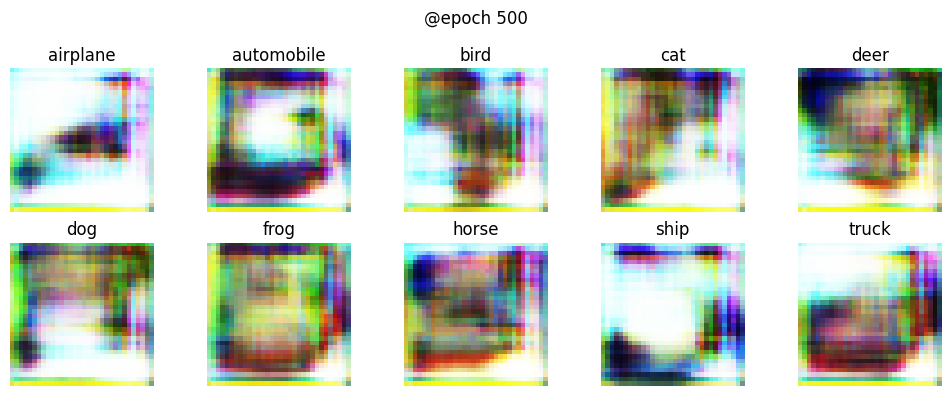

600/10000 | d_loss = 1.666130781173706, d_valid_accuracy = 0.0, d_class accuracy = 0.56449294090271| comb_loss = 0.7823546528816223, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
700/10000 | d_loss = 1.646658182144165, d_valid_accuracy = 0.0, d_class accuracy = 0.5816586017608643| comb_loss = 0.7509891986846924, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
800/10000 | d_loss = 1.6272635459899902, d_valid_accuracy = 0.0, d_class accuracy = 0.5954399108886719| comb_loss = 0.7263224124908447, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
900/10000 | d_loss = 1.6058157682418823, d_valid_accuracy = 0.0, d_class accuracy = 0.6066094636917114| comb_loss = 0.7109577059745789, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.     

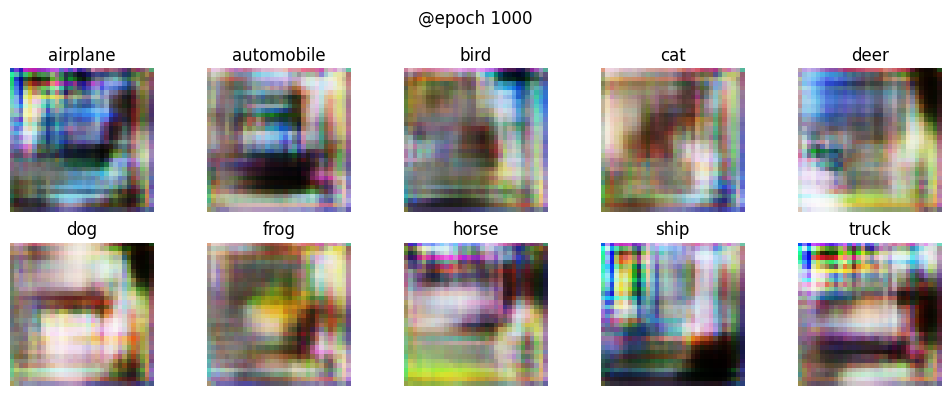

1100/10000 | d_loss = 1.5696709156036377, d_valid_accuracy = 0.0, d_class accuracy = 0.6241617202758789| comb_loss = 0.6645846366882324, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
1200/10000 | d_loss = 1.5560235977172852, d_valid_accuracy = 0.0, d_class accuracy = 0.6311144828796387| comb_loss = 0.6538203358650208, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
1300/10000 | d_loss = 1.5393707752227783, d_valid_accuracy = 0.0, d_class accuracy = 0.6374603509902954| comb_loss = 0.6313143968582153, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
1400/10000 | d_loss = 1.5275300741195679, d_valid_accuracy = 0.0, d_class accuracy = 0.6428881883621216| comb_loss = 0.618247389793396, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 

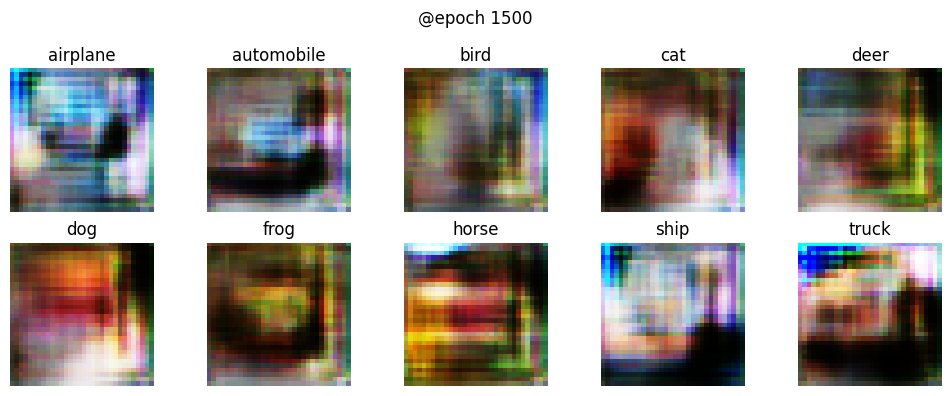

1600/10000 | d_loss = 1.5000455379486084, d_valid_accuracy = 0.0, d_class accuracy = 0.6516398787498474| comb_loss = 0.5874345898628235, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
1700/10000 | d_loss = 1.4851760864257812, d_valid_accuracy = 0.0, d_class accuracy = 0.6554548740386963| comb_loss = 0.5765665769577026, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
1800/10000 | d_loss = 1.4709501266479492, d_valid_accuracy = 0.0, d_class accuracy = 0.6593624353408813| comb_loss = 0.5649019479751587, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
1900/10000 | d_loss = 1.4589414596557617, d_valid_accuracy = 0.0, d_class accuracy = 0.6624556183815002| comb_loss = 0.5543391704559326, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545

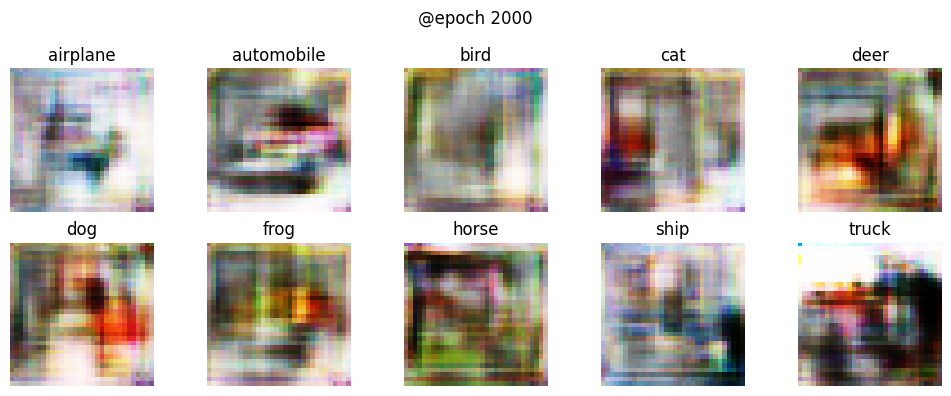

2100/10000 | d_loss = 1.4425300359725952, d_valid_accuracy = 0.0, d_class accuracy = 0.6682119369506836| comb_loss = 0.5391903519630432, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
2200/10000 | d_loss = 1.4369444847106934, d_valid_accuracy = 0.0, d_class accuracy = 0.6707829236984253| comb_loss = 0.5333501696586609, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
2300/10000 | d_loss = 1.4252302646636963, d_valid_accuracy = 0.0, d_class accuracy = 0.6731404066085815| comb_loss = 0.5201548337936401, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
2400/10000 | d_loss = 1.4196844100952148, d_valid_accuracy = 0.0, d_class accuracy = 0.6755748987197876| comb_loss = 0.5173245668411255, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545

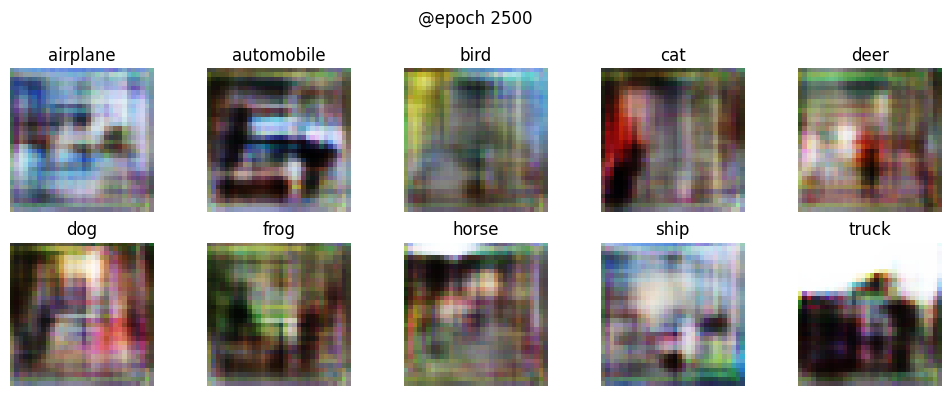

2600/10000 | d_loss = 1.4118320941925049, d_valid_accuracy = 0.0, d_class accuracy = 0.6798520088195801| comb_loss = 0.5090381503105164, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
2700/10000 | d_loss = 1.406599998474121, d_valid_accuracy = 0.0, d_class accuracy = 0.6817760467529297| comb_loss = 0.5035791993141174, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
2800/10000 | d_loss = 1.3995044231414795, d_valid_accuracy = 0.0, d_class accuracy = 0.6836101412773132| comb_loss = 0.4969969689846039, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
2900/10000 | d_loss = 1.3901035785675049, d_valid_accuracy = 0.0, d_class accuracy = 0.6856436729431152| comb_loss = 0.4889853894710541, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 

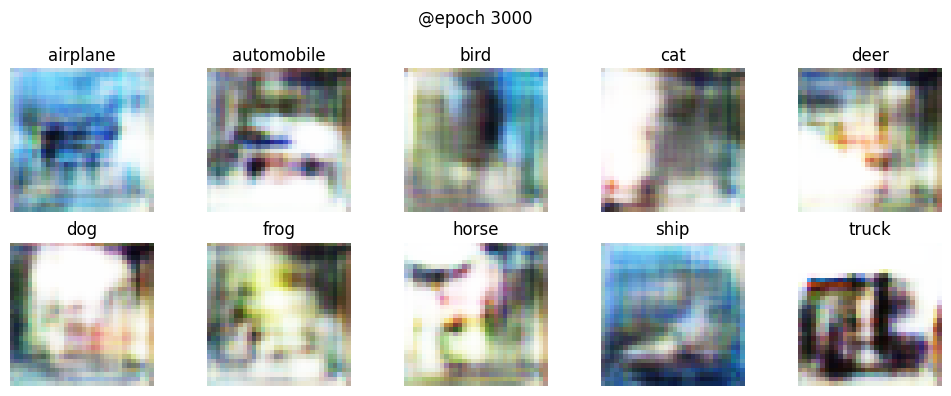

3100/10000 | d_loss = 1.3766543865203857, d_valid_accuracy = 0.0, d_class accuracy = 0.6888509392738342| comb_loss = 0.4767206609249115, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
3200/10000 | d_loss = 1.3714669942855835, d_valid_accuracy = 0.0, d_class accuracy = 0.6905031204223633| comb_loss = 0.47100400924682617, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
3300/10000 | d_loss = 1.3661532402038574, d_valid_accuracy = 0.0, d_class accuracy = 0.6921097040176392| comb_loss = 0.4688824415206909, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
3400/10000 | d_loss = 1.3612041473388672, d_valid_accuracy = 0.0, d_class accuracy = 0.693601131439209| comb_loss = 0.4634508192539215, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545

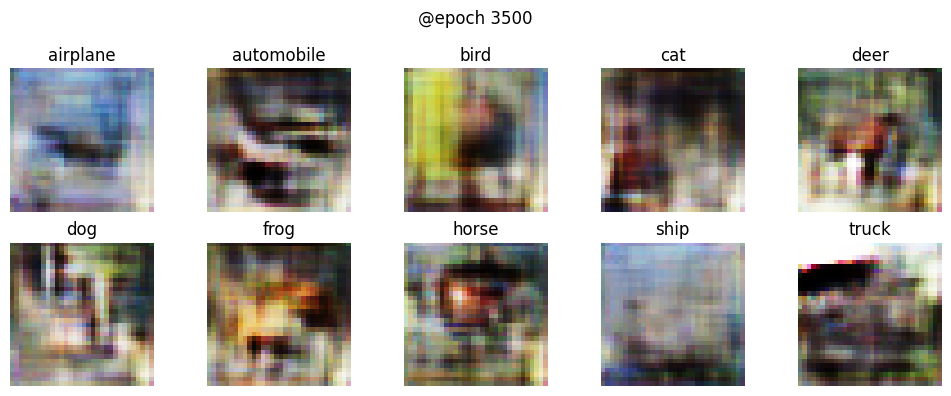

3600/10000 | d_loss = 1.3588778972625732, d_valid_accuracy = 0.0, d_class accuracy = 0.6963808536529541| comb_loss = 0.46239590644836426, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
3700/10000 | d_loss = 1.3570172786712646, d_valid_accuracy = 0.0, d_class accuracy = 0.6978195905685425| comb_loss = 0.4611535966396332, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
3800/10000 | d_loss = 1.3528445959091187, d_valid_accuracy = 0.0, d_class accuracy = 0.6991331577301025| comb_loss = 0.45801863074302673, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
3900/10000 | d_loss = 1.3470261096954346, d_valid_accuracy = 0.0, d_class accuracy = 0.7004595398902893| comb_loss = 0.45249494910240173, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138

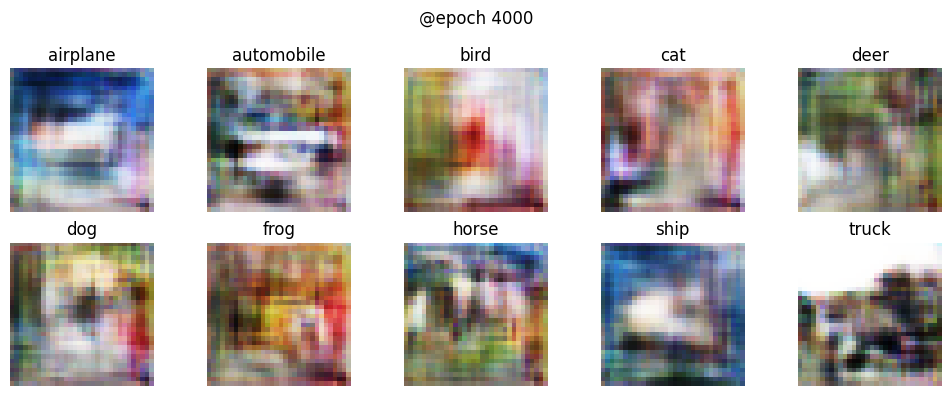

4100/10000 | d_loss = 1.3426964282989502, d_valid_accuracy = 0.0, d_class accuracy = 0.7029182314872742| comb_loss = 0.4493712782859802, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
4200/10000 | d_loss = 1.337634801864624, d_valid_accuracy = 0.0, d_class accuracy = 0.7042644023895264| comb_loss = 0.4453781247138977, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
4300/10000 | d_loss = 1.3317385911941528, d_valid_accuracy = 0.0, d_class accuracy = 0.7056279182434082| comb_loss = 0.44133657217025757, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
4400/10000 | d_loss = 1.3277935981750488, d_valid_accuracy = 0.0, d_class accuracy = 0.7067731618881226| comb_loss = 0.44009384512901306, accuracy(valid, class) = ([2.9437706 2.3138545 2.313854

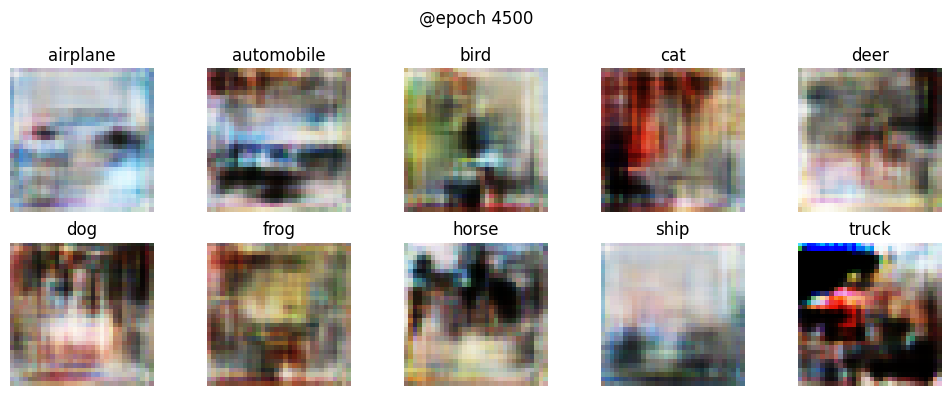

4600/10000 | d_loss = 1.3188633918762207, d_valid_accuracy = 0.0, d_class accuracy = 0.7089701890945435| comb_loss = 0.43350639939308167, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
4700/10000 | d_loss = 1.3173803091049194, d_valid_accuracy = 0.0, d_class accuracy = 0.7099679708480835| comb_loss = 0.4321662187576294, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
4800/10000 | d_loss = 1.311895489692688, d_valid_accuracy = 0.0, d_class accuracy = 0.7109924554824829| comb_loss = 0.42781949043273926, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
4900/10000 | d_loss = 1.3086711168289185, d_valid_accuracy = 0.0, d_class accuracy = 0.7120085954666138| comb_loss = 0.42564767599105835, accuracy(valid, class) = ([2.9437706 2.3138545 2.31385

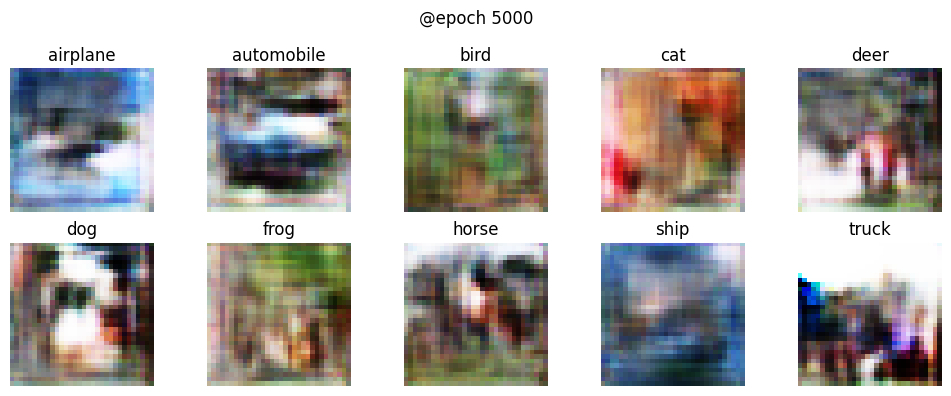

5100/10000 | d_loss = 1.3008310794830322, d_valid_accuracy = 0.0, d_class accuracy = 0.713968813419342| comb_loss = 0.4206252694129944, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
5200/10000 | d_loss = 1.2969534397125244, d_valid_accuracy = 0.0, d_class accuracy = 0.7148104906082153| comb_loss = 0.41764017939567566, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
5300/10000 | d_loss = 1.2937887907028198, d_valid_accuracy = 0.0, d_class accuracy = 0.7157383561134338| comb_loss = 0.41569939255714417, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
5400/10000 | d_loss = 1.2896844148635864, d_valid_accuracy = 0.0, d_class accuracy = 0.7166491746902466| comb_loss = 0.41276460886001587, accuracy(valid, class) = ([2.9437706 2.3138545 2.31385

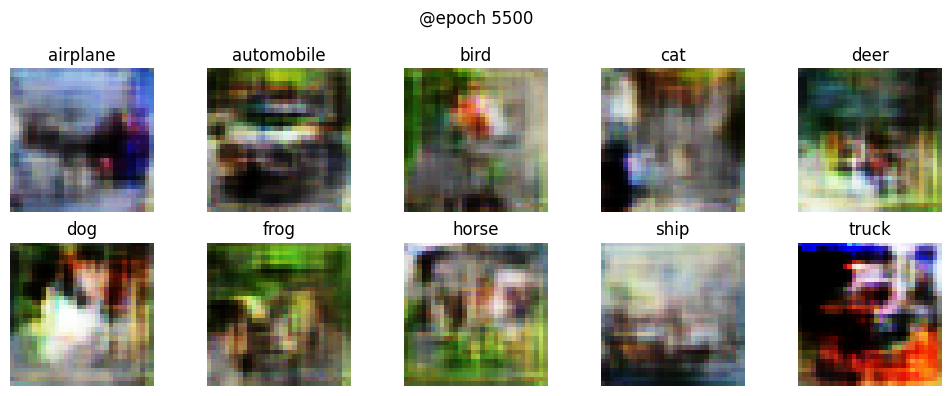

5600/10000 | d_loss = 1.286210060119629, d_valid_accuracy = 0.0, d_class accuracy = 0.7182491421699524| comb_loss = 0.4099511206150055, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
5700/10000 | d_loss = 1.2838115692138672, d_valid_accuracy = 0.0, d_class accuracy = 0.7190337181091309| comb_loss = 0.4079362750053406, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
5800/10000 | d_loss = 1.282090663909912, d_valid_accuracy = 0.0, d_class accuracy = 0.7197266221046448| comb_loss = 0.40647515654563904, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
5900/10000 | d_loss = 1.2789053916931152, d_valid_accuracy = 0.0, d_class accuracy = 0.7205801010131836| comb_loss = 0.40417084097862244, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545

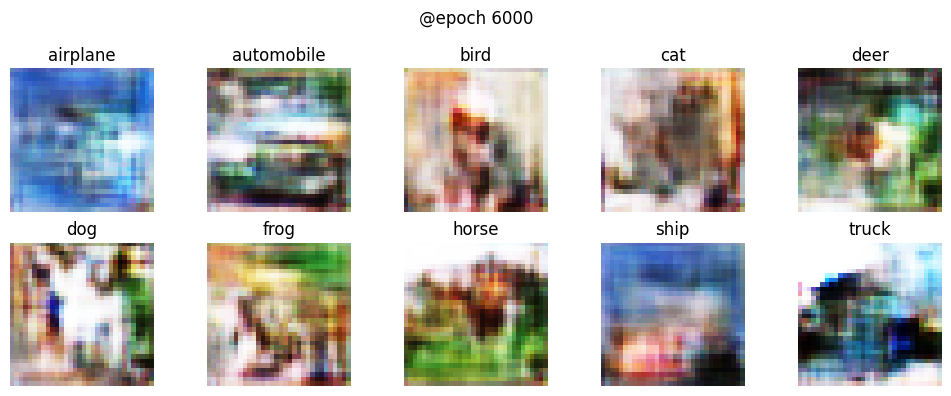

6100/10000 | d_loss = 1.2740676403045654, d_valid_accuracy = 0.0, d_class accuracy = 0.7221390008926392| comb_loss = 0.4029129445552826, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
6200/10000 | d_loss = 1.2713351249694824, d_valid_accuracy = 0.0, d_class accuracy = 0.7228732109069824| comb_loss = 0.40030428767204285, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
6300/10000 | d_loss = 1.2706499099731445, d_valid_accuracy = 0.0, d_class accuracy = 0.723595142364502| comb_loss = 0.40079861879348755, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
6400/10000 | d_loss = 1.269175410270691, d_valid_accuracy = 0.0, d_class accuracy = 0.7242995500564575| comb_loss = 0.4001798927783966, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545

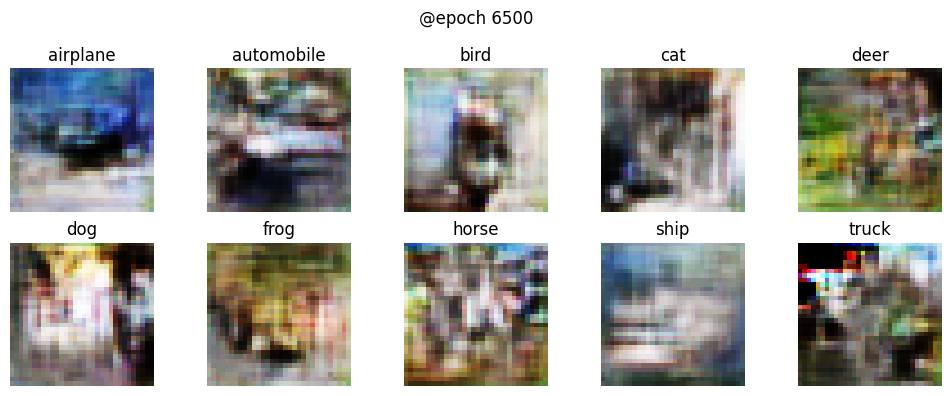

6600/10000 | d_loss = 1.2646722793579102, d_valid_accuracy = 0.0, d_class accuracy = 0.7255246639251709| comb_loss = 0.39636948704719543, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
6700/10000 | d_loss = 1.2607316970825195, d_valid_accuracy = 0.0, d_class accuracy = 0.7261943817138672| comb_loss = 0.3943934738636017, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
6800/10000 | d_loss = 1.2577581405639648, d_valid_accuracy = 0.0, d_class accuracy = 0.7268052101135254| comb_loss = 0.39314717054367065, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
6900/10000 | d_loss = 1.255054235458374, d_valid_accuracy = 0.0, d_class accuracy = 0.727453887462616| comb_loss = 0.39168646931648254, accuracy(valid, class) = ([2.9437706 2.3138545 2.313854

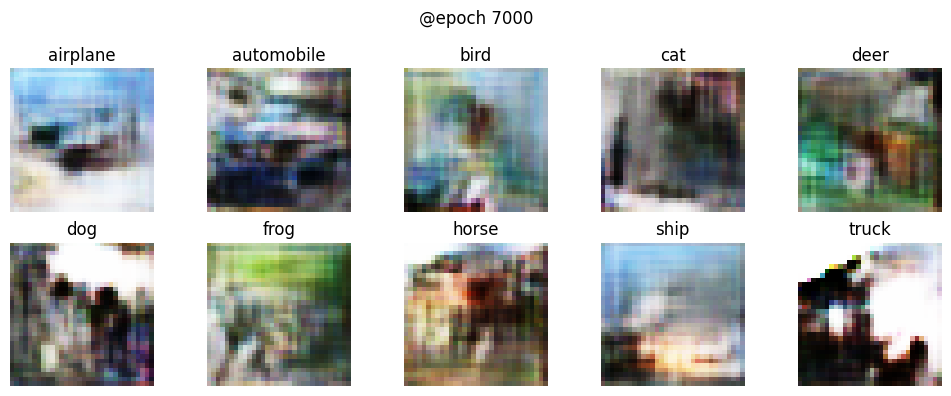

7100/10000 | d_loss = 1.2522398233413696, d_valid_accuracy = 0.0, d_class accuracy = 0.7287546992301941| comb_loss = 0.3895338475704193, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
7200/10000 | d_loss = 1.2509894371032715, d_valid_accuracy = 0.0, d_class accuracy = 0.7293232679367065| comb_loss = 0.3884584307670593, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
7300/10000 | d_loss = 1.2473714351654053, d_valid_accuracy = 0.0, d_class accuracy = 0.7298890948295593| comb_loss = 0.3864433467388153, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
7400/10000 | d_loss = 1.244987964630127, d_valid_accuracy = 0.0, d_class accuracy = 0.7304100394248962| comb_loss = 0.38558992743492126, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545

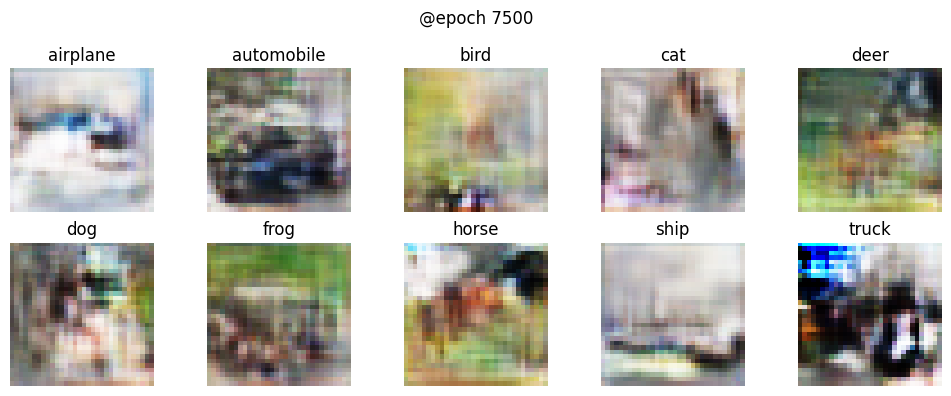

7600/10000 | d_loss = 1.2406162023544312, d_valid_accuracy = 0.0, d_class accuracy = 0.7316256761550903| comb_loss = 0.3833516836166382, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
7700/10000 | d_loss = 1.2382676601409912, d_valid_accuracy = 0.0, d_class accuracy = 0.7322325706481934| comb_loss = 0.3828093707561493, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
7800/10000 | d_loss = 1.2356443405151367, d_valid_accuracy = 0.0, d_class accuracy = 0.7327288389205933| comb_loss = 0.3809249997138977, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
7900/10000 | d_loss = 1.232590675354004, d_valid_accuracy = 0.0, d_class accuracy = 0.7332965135574341| comb_loss = 0.37960031628608704, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545

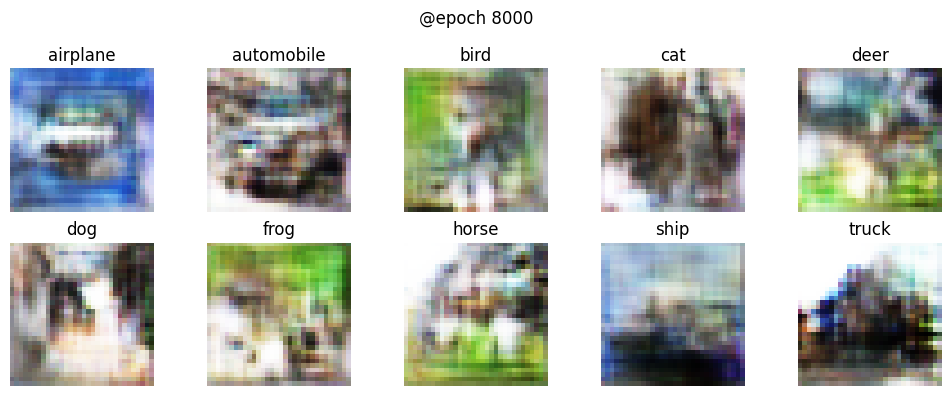

8100/10000 | d_loss = 1.2292428016662598, d_valid_accuracy = 0.0, d_class accuracy = 0.7342443466186523| comb_loss = 0.3776068389415741, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
8200/10000 | d_loss = 1.226509690284729, d_valid_accuracy = 0.0, d_class accuracy = 0.734711766242981| comb_loss = 0.37572914361953735, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
8300/10000 | d_loss = 1.2240090370178223, d_valid_accuracy = 0.0, d_class accuracy = 0.7351821660995483| comb_loss = 0.3742978870868683, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
8400/10000 | d_loss = 1.2221344709396362, d_valid_accuracy = 0.0, d_class accuracy = 0.7356738448143005| comb_loss = 0.373750239610672, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0

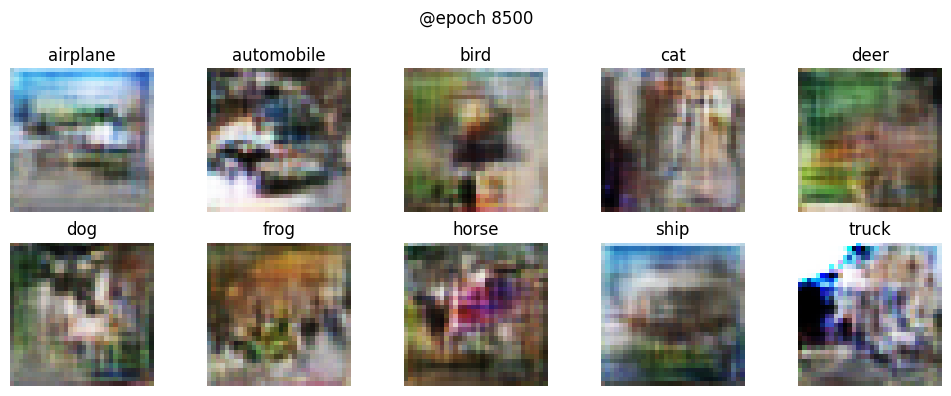

8600/10000 | d_loss = 1.220569133758545, d_valid_accuracy = 0.0, d_class accuracy = 0.7365766763687134| comb_loss = 0.3726361393928528, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
8700/10000 | d_loss = 1.2190184593200684, d_valid_accuracy = 0.0, d_class accuracy = 0.7369904518127441| comb_loss = 0.37122565507888794, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
8800/10000 | d_loss = 1.2173264026641846, d_valid_accuracy = 0.0, d_class accuracy = 0.7373851537704468| comb_loss = 0.37032416462898254, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
8900/10000 | d_loss = 1.2152235507965088, d_valid_accuracy = 0.0, d_class accuracy = 0.7378955483436584| comb_loss = 0.36896201968193054, accuracy(valid, class) = ([2.9437706 2.3138545 2.31385

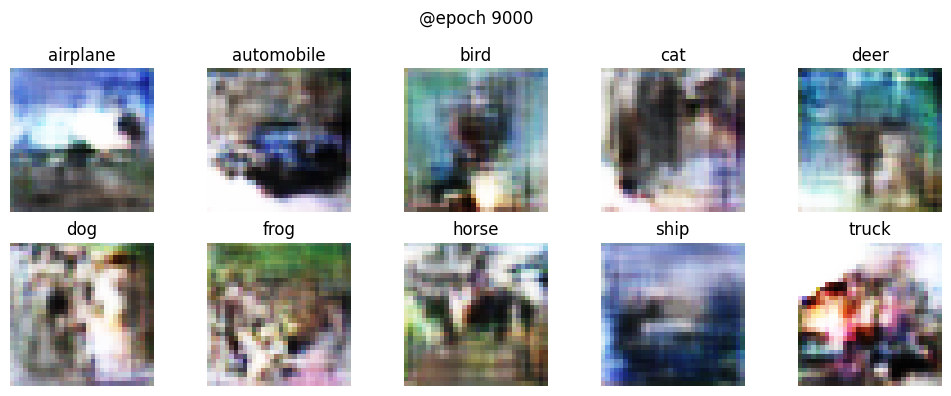

9100/10000 | d_loss = 1.2117881774902344, d_valid_accuracy = 0.0, d_class accuracy = 0.7387840747833252| comb_loss = 0.3670063316822052, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
9200/10000 | d_loss = 1.2092764377593994, d_valid_accuracy = 0.0, d_class accuracy = 0.7392541170120239| comb_loss = 0.36563000082969666, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
9300/10000 | d_loss = 1.2073543071746826, d_valid_accuracy = 0.0, d_class accuracy = 0.7396948337554932| comb_loss = 0.36456751823425293, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
9400/10000 | d_loss = 1.205113410949707, d_valid_accuracy = 0.0, d_class accuracy = 0.7401027679443359| comb_loss = 0.36313363909721375, accuracy(valid, class) = ([2.9437706 2.3138545 2.31385

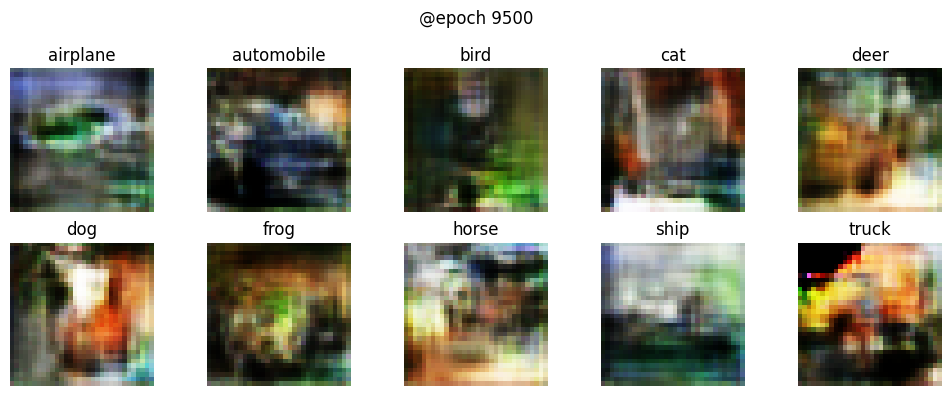

9600/10000 | d_loss = 1.200653076171875, d_valid_accuracy = 0.0, d_class accuracy = 0.741003155708313| comb_loss = 0.3614204525947571, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
9700/10000 | d_loss = 1.1986820697784424, d_valid_accuracy = 0.0, d_class accuracy = 0.7414455413818359| comb_loss = 0.3604223430156708, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
9800/10000 | d_loss = 1.1963456869125366, d_valid_accuracy = 0.0, d_class accuracy = 0.7419154644012451| comb_loss = 0.359524130821228, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0.        0.109375 ], [2.93066   2.3177636 2.3177636 0.        0.096875 ])
9900/10000 | d_loss = 1.1944859027862549, d_valid_accuracy = 0.0, d_class accuracy = 0.7423191070556641| comb_loss = 0.35861390829086304, accuracy(valid, class) = ([2.9437706 2.3138545 2.3138545 0

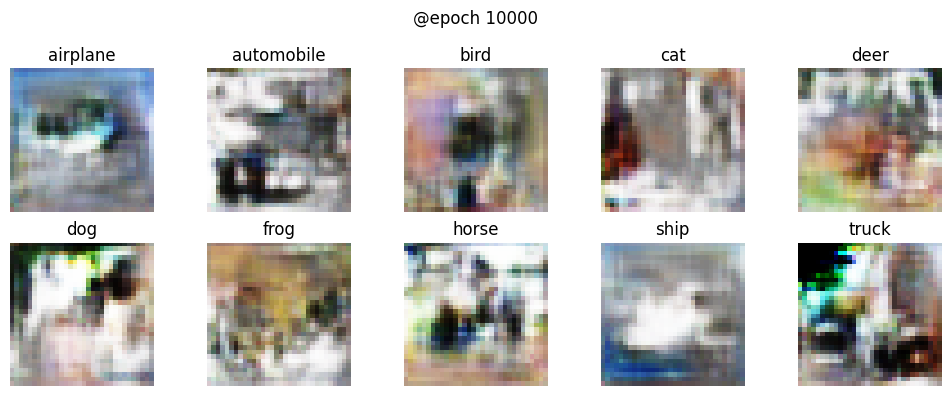

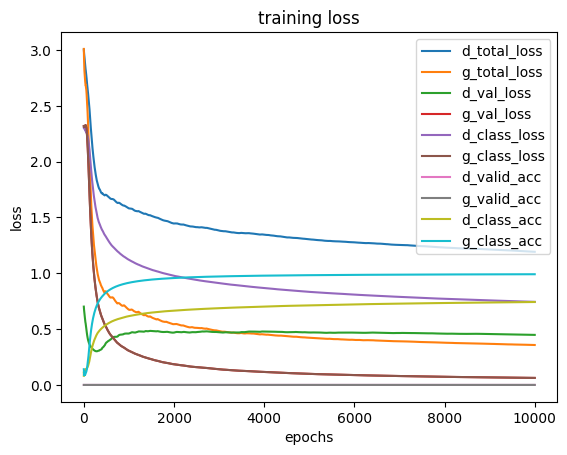

In [17]:
d_loss, g_loss = train_model(10000, x_train_shuffled_norm, y_train_shuffled)